# Math 189

### Setup

In [2]:
# Imports
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load the data
df = pd.read_csv('capes_data.csv')
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,Percentage Recommended Class,Percentage Recommended Professor,Study Hours per Week,Average Grade Expected,Average Grade Received,Evalulation URL
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,93.5%,100.0%,2.80,A- (3.84),B+ (3.67),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,100.0%,100.0%,2.50,A- (3.86),A- (3.92),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
2,Jones Ian William Nasser,ANAR 111 - Foundations of Archaeology (A),SP23,16,3,100.0%,100.0%,3.83,B+ (3.67),NaN,https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
3,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,100.0%,83.3%,3.83,B+ (3.50),B (3.07),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
4,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,100.0%,100.0%,5.17,A (4.00),A (4.00),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...


### Data Cleaning

Since the evaluation URL does not have any influence on our result, it will be deleted. The name of the instructors will also be removed to streamline our analysis towards more generalizable insights focusing on other relevant variables. In addition, rows containing missing values will be eliminated.

In [4]:
df = df.drop('Evalulation URL', axis=1)
df = df.drop('Instructor', axis=1)
df = df.dropna().reset_index(drop=True)

For later analysis, we will only preserve the numerical GPA from `Average Grade Expected` and `Average Grade Received`.

In [5]:
df['exp_gpa'] = df['Average Grade Expected'].str.extract(r'(\d+\.\d+)').astype(float)
df['rec_gpa'] = df['Average Grade Received'].str.extract(r'(\d+\.\d+)').astype(float)

df = df.drop('Average Grade Expected', axis=1)
df = df.drop('Average Grade Received', axis=1)

We extract the season part from `Quarter` and rename them as `season`.

In [6]:
df['season'] = df['Quarter'].str[0:2]
df['season'] = df['season'].replace(['S1', 'S2', 'S3', 'SU'], 'SS')
df['season'] = df['season'].astype('category')
df['Quarter'] = df['Quarter'].astype('category')

Proportion of people filling CAPES will be used to replace the number of those filling CAPES.

In [7]:
df['cape_prop'] = df['Total CAPEs Given']/df['Total Enrolled in Course']
df = df.drop('Total CAPEs Given', axis=1)

In order to ensure our data is representative, we will drop courses with survey response rates below 50%.

In [8]:
# Only take rows with more than 50% evaluating proportion
df = df[df['cape_prop'] > 0.50] # 45393 -> 18860

Two key information will be extracted from the name of each course: which subject code does the course have and whether it is an upper course or lower course.

In [9]:
course_info = df['Course'].apply(lambda x: re.findall(r"[\w+\s\d+]+\b", x)[0])
print(f"In total there are {course_info.apply(lambda x: x.split()[0]).value_counts().shape[0]} subject codes")

df['Course'] = pd.Series(course_info).apply(lambda x: x.split()[0])
if_lower = course_info.apply(lambda x: x.split()[1]).apply(lambda x: 1 if int(re.findall(r"\d+", x)[0]) < 100 else 0)
df['if_lower'] = if_lower
df.rename(columns={"Course" : "subject_code"}, inplace=True)

df['if_lower'] = df['if_lower'].astype('category')
df['subject_code'] = df['subject_code'].astype('category')

In total there are 121 subject codes


We will convert the subject codes into different fields.

In [10]:
# Natural and Physical Sciences
nat_phys_sci = [
    "ASTR", "BIBC", "BICD", "BIEB", "BILD", "BIMM", "BIPN", "BISP", 
    "CHEM", "CMM", "COGS", "DSC", "DSE", "MATH", "PHYS", "PHYA", 
    "SIO", "SIOB", "SIOC", "SIOG"
]

# Engineering and Technology
eng_tech = [
    "AESE", "BENG", "CENG", "COSE", "CSE", "ECE", "ENG", "MAE", "MATS", 
    "NANO", "SE", "WES"
]

# Health and Medicine
# health_med = [
#     "ANES", "BIOM", "CLIN", "CLRE", "DERM", "EMED", "FMPH", "GLBH", 
#     "HLAW", "LHCO", "MED", "NEU", "NEUG", "OBG", "OPTH", "ORTH", 
#     "PAE", "PATH", "PEDS", "PHAR", "PSY", "RAD", "RMAS", "RMED", 
#     "SOMC", "SOMI", "SPPS", "SURG", "UROL", "FPMU"
# ]

# Art and Design
art_design = [
    "COCU", "COGN", "COSF", "COHI", "COMT", "DSGN", "FILM", "ICAM", 
    "MUS", "TDAC", "TDCH", "TDDE", "TDDM", "TDDR", "TDGE", "TDGR", 
    "TDHD", "TDHT", "TDMV", "TDPF", "TDPR", "TDPW", "TDTR", "VIS"
]

# Humanities and Social Sciences
human_soc_sci = [
    "AAPI", "AAS", "ANAR", "ANBI", "ANSC", "ANTH", "CGS", "CCS", "CCE",
    "CHIN", "CLAS", "COMM", "CONT", "CSS", "ECON", "EDS", "ENVR", "ERC",
    "ESYS", "ETHN", "ETIM", "GSS", "GMST", "HDP", "HDS", "HIAF", "HIEA",
    "HIEU", "HILA", "HILD", "HINE", "HISC", "HITO", "HIUS", "HMNR", "HUM",
    "INTL", "JAPN", "JUDA", "JWSP", "LAWS", "LATI", "LIHL", "LTAF", "LTAM",
    "LTCH", "LTCS", "LTEA", "LTEN", "LTEU", "LTFR", "LTGM", "LTGK", "LTHI",
    "LIGN", "LTLA", "LTRU", "LTSP", "LTTH", "LTWR", "LTIT", "LTKO", "LTKS",
    "LTWL", "LTCO", "MGTA", "MGT", "MGTF", "MGTP", "PHIL", "POLI", "PSYC",
    "RELI", "SOCA", "SOCB", "SOCC", "SOCD", "SOCE", "SOCI", "SOCL", "STPA",
    "TKS", "TWS", "USP", "GLBH", "FMPH", "FPMU"
]



# College and Writing Programs
col_write_prog = [
    "AWP", "CAT", "DOC", "EAP", "ELWR", "ERC", "EIGH", "MCWP", "MMW", 
    "MSP", "MUIR", "REV", "SEV", "SXTH", "SYN", "TMC", "WARR", "WCWP"
]


Note: Subject Codes acquired from [here](https://blink.ucsd.edu/instructors/courses/schedule-of-classes/subject-codes.html)

In [11]:
def set_field(course):
    if course in eng_tech:
        return "eng_tech"
    elif course in nat_phys_sci:
        return "nat_phys_sci"
    # elif course in health_med:
    #     return "health_med"
    elif course in human_soc_sci:
        return "human_soc_sci"
    elif course in art_design:
        return "art_design"
    elif course in col_write_prog:
        return "col_write_prog"
    return np.nan

df["field"] = df['subject_code'].apply(set_field)

Some other columns will be renamed for simplicity and converted to appropriate data types.

In [12]:
df = df.rename(columns={
    'Percentage Recommended Class': 'recmd_class',
    'Percentage Recommended Professor': 'recmd_prof',
    'Study Hours per Week': 'study_hrs',
    'Total Enrolled in Course' : 'enrollment'
})

df['recmd_class'] = df['recmd_class'].str.extract(r'(\d+)').astype(float)/100
df['recmd_prof'] = df['recmd_prof'].str.extract(r'(\d+)').astype(float)/100

The sequence number will be updated. 

In [13]:
df = df.reset_index(drop=True)

Now, let's take a look at the cleaned dataset.

In [14]:
df.head()

,subject_code,Quarter,enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,rec_gpa,season,cape_prop,if_lower,field
0,AAS,SP23,66,0.93,1.00,2.80,3.84,3.67,SP,0.727273,1,human_soc_sci
1,ANSC,SP23,30,0.95,1.00,3.45,3.79,3.67,SP,0.666667,0,human_soc_sci
2,ANSC,SP23,36,0.92,0.96,4.02,3.60,3.40,SP,0.694444,0,human_soc_sci
3,ANSC,SP23,24,1.00,1.00,3.56,4.00,3.91,SP,0.708333,0,human_soc_sci
4,ANTH,SP23,74,0.98,1.00,3.01,3.72,3.75,SP,0.702703,1,human_soc_sci


### Exploratory Data Analysis

We can obtain a general understanding of the distribution of the average grade received by drawing a histogram before further analysis.

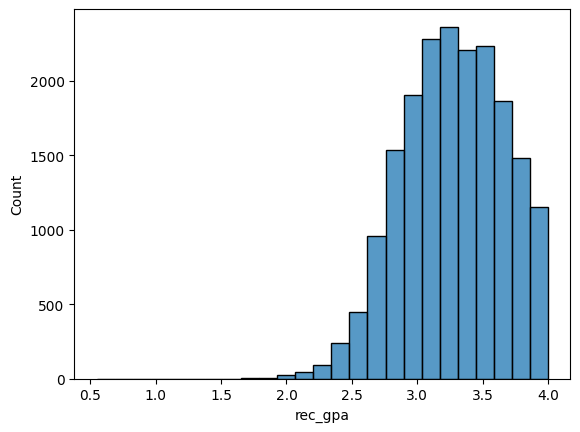

In [15]:
sns.histplot(df['rec_gpa'], bins=25)
plt.show()

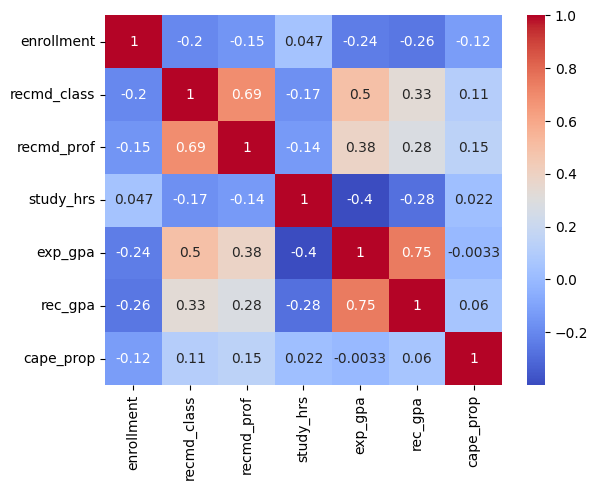

In [16]:
# Correlation
quan_data = df.drop(columns={
    'subject_code',
    'field',
    'Quarter',
    'season',
    'if_lower'
})
correlation_matrix = quan_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Hypothesis Testing

### Regression Analysis

We will first perform a regular linear regression based on all the covariates we have obtained so far.

In [17]:
formula = 'rec_gpa ~ enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + season + cape_prop + if_lower+field'
model = smf.ols(formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                rec_gpa   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     1832.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:44:41   Log-Likelihood:                -904.47
No. Observations:               18860   AIC:                             1839.
Df Residuals:                   18845   BIC:                             1957.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

##### Assumptions

In [18]:
def standardize(X):
    return (X - X.mean()) / X.std()

residuals = standardize(model.resid)

1. Normality

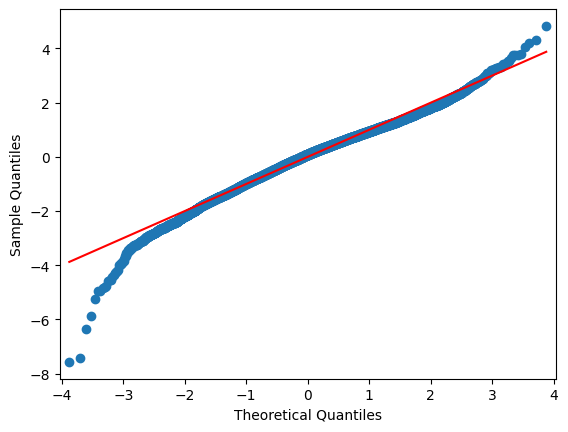

In [19]:
sm.qqplot(residuals, line='s');

Although violated, We only care about the values
what do people do if they have non-normal residual

In [20]:
import warnings
warnings.filterwarnings('ignore')

alpha = 0.05

shapiro = stats.shapiro(residuals)

print('Shapiro-Wilk test p-value: ', shapiro[1])

if shapiro[1] < alpha:
    print('The residuals are not normally distributed')
else:
    print('The residuals are normally distributed')

Shapiro-Wilk test p-value:  1.5166217854562317e-36
The residuals are not normally distributed


By looking at the qqplot and running the Shapiro-Wilk test, we can see that the normality assumption has been violated. We did try to fix this issue by applying transformations such as log and square root. Unfortunately, the problem still exists.

In [21]:
log_y = np.log(df['rec_gpa'])
log_formula = 'log_y ~ enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + season + cape_prop + if_lower + field'
log_model = smf.ols(log_formula, data=df).fit()
log_residuals = standardize(log_model.resid)

shapiro = stats.shapiro(log_residuals)
print('Shapiro-Wilk test p-value: ', shapiro[1])
if shapiro[1] < alpha:
    print('The residuals are not normally distributed')
else:
    print('The residuals are normally distributed')

Shapiro-Wilk test p-value:  0.0
The residuals are not normally distributed


In [22]:
sqrt_y = np.sqrt(df['rec_gpa'])
sqrt_formula = 'sqrt_y ~ enrollment + recmd_class + recmd_prof + study_hrs + exp_gpa + season + cape_prop + if_lower + field'
sqrt_model = smf.ols(sqrt_formula, data=df).fit()
sqrt_residuals = standardize(sqrt_model.resid)

shapiro = stats.shapiro(sqrt_residuals)
print('Shapiro-Wilk test p-value: ', shapiro[1])
if shapiro[1] < alpha:
    print('The residuals are not normally distributed')
else:
    print('The residuals are normally distributed')

Shapiro-Wilk test p-value:  5.605193857299268e-45
The residuals are not normally distributed


2. Independence

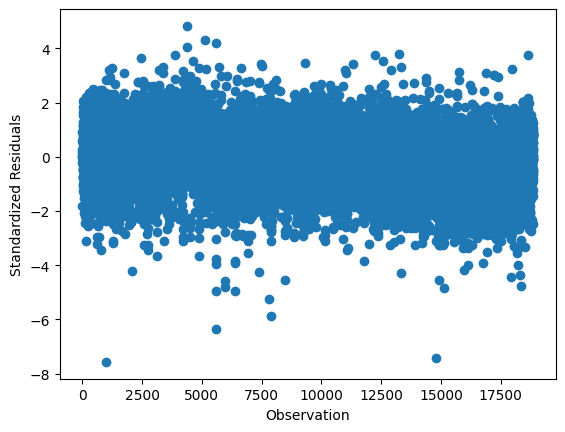

In [23]:
# scatter plot of residuals vs observation index
plt.scatter(range(len(residuals)), residuals);
plt.xlabel('Observation');
plt.ylabel('Standardized Residuals');

Based on the plot, the points are randomly distributed, which means that the independence of residuals assumption is statisfied.

3. Linearity

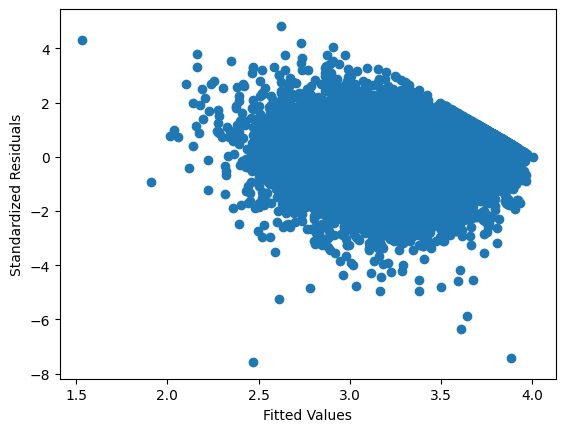

In [24]:
# scatter plot of residuals vs fitted values
plt.scatter(model.fittedvalues, residuals);
plt.xlabel('Fitted Values');
plt.ylabel('Standardized Residuals');

Based on the plot, the linear assumption has been satisfied.

4. Homoscedasticity

In [25]:
from statsmodels.stats.diagnostic import het_breuschpagan

alpha = 0.05

p_values = het_breuschpagan(model.resid, model.model.exog)[3]
print(p_values)

if p_values < alpha:
    print('The residuals are heteroscedastic')
else:
    print('The residuals are homoscedastic')

7.988066298643586e-134
The residuals are heteroscedastic


By running the Breusch-Pagan Test, the homoscedasticity assumption has been violated. However, the estimated coefficients remain unbiased. Since we are only interested in the values instead of the variance and confidence intervals, it doesn't have significant impact on our model.


5. Non-Multicollinearity

In [26]:
exog = model.model.exog
names = model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i):.3f}')

VIF: season[T.SP]: 1.324
VIF: season[T.SS]: 1.192
VIF: season[T.WI]: 1.318
VIF: if_lower[T.1]: 1.200
VIF: field[T.col_write_prog]: 1.867
VIF: field[T.eng_tech]: 3.116
VIF: field[T.human_soc_sci]: 3.676
VIF: field[T.nat_phys_sci]: 3.647
VIF: enrollment: 1.307
VIF: recmd_class: 2.414
VIF: recmd_prof: 2.060
VIF: study_hrs: 1.674
VIF: exp_gpa: 1.691
VIF: cape_prop: 1.063


Given that the VIFs do not exceed a threshold of $5$, the multicollinearity is small.

This part checks if the students recieved GPA is significantly impacted compare to the gpa students received before the COVID period. It could be much better or worse. 

Definition of Covid in terms of UCSD Quarters: Quarters from Summer Session 2020 to SPing 2023. Both inclusive.

SS20 FA20 WI21 SP21 SS21 FA21 WI22 SP22 SS22 FA22 WI23 SP23

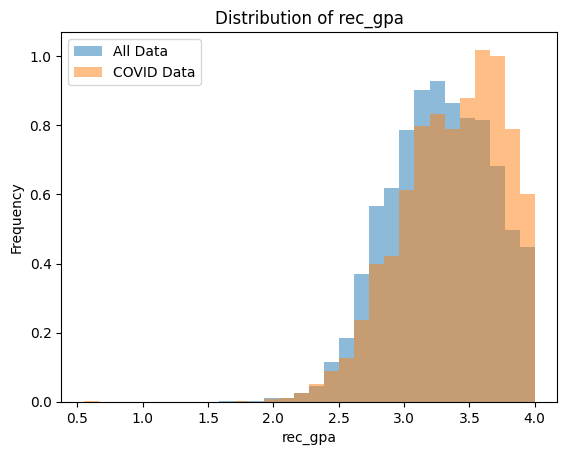

In [27]:
# Permutation test to see if the data is different

df_covid = df[df['Quarter'].apply(lambda x : x in ['SS20', 'FA20', 'WI21', 'SP21', 'SS21', 'FA21', 'WI22', 'SP22', 'SS22', 'FA22', 'WI23', 'SP23'])]
# df['rec_gpa'].mean() 3.27194
# df_covid['rec_gpa'].mean() 3.390616

plt.hist(df['rec_gpa'], bins=30, alpha=0.5, label='All Data',density=True)
plt.hist(df_covid['rec_gpa'], bins=30, alpha=0.5, label='COVID Data', density=True)

plt.title('Distribution of rec_gpa')
plt.xlabel('rec_gpa')
plt.ylabel('Frequency')
plt.legend()
plt.show()


It looks like the GPA during the Covid time is slightly higher than other time.  
In order to justify that, lets do a permutation test!

P-value: 0.448


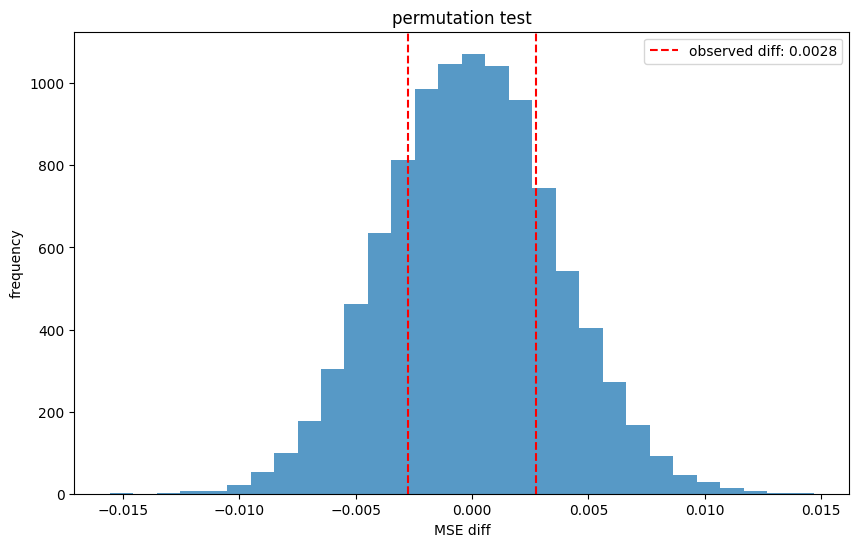

In [28]:
def mse_difference(data1, data2):
    return np.mean((data1 - np.mean(data2)) ** 2) - np.mean((data2 - np.mean(data1)) ** 2)


observed_mse_diff = mse_difference(df_covid['rec_gpa'], df[~df['Quarter'].isin(df_covid['Quarter'])]['rec_gpa'])

combined_data = np.concatenate([df_covid['rec_gpa'], df[~df['Quarter'].isin(df_covid['Quarter'])]['rec_gpa']])

num_permutations = 10000

permuted_mse_diffs = np.zeros(num_permutations)

for i in range(num_permutations):

    permuted_data = np.random.permutation(combined_data)

    permuted_sample1 = permuted_data[:len(df_covid)]
    permuted_sample2 = permuted_data[len(df_covid):]

    permuted_mse_diffs[i] = mse_difference(permuted_sample1, permuted_sample2)

p_value = np.mean(np.abs(permuted_mse_diffs) >= np.abs(observed_mse_diff))

# print(f'Observed mse diff: {observed_mse_diff}')
print(f'P-value: {p_value}')


plt.figure(figsize=(10, 6))
plt.hist(permuted_mse_diffs, bins=30, alpha=0.75)
plt.axvline(observed_mse_diff, color='red', linestyle='--', label=f'observed diff: {observed_mse_diff:.4f}')
plt.axvline(-observed_mse_diff, color='red', linestyle='--')
plt.title('permutation test')
plt.xlabel('MSE diff')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [29]:
X = df[['enrollment', 'recmd_class', 'recmd_prof', 'study_hrs', 'exp_gpa', 'cape_prop', 'if_lower']]
y = df['rec_gpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Correlation coefficient score: {r2}')

Mean Squared Error: 0.06380130993759016
Correlation coefficient score: 0.5848281941880169


In [30]:
# Prediction to a made-up date
new_data = [[30, 0.95, 0.90, 3.0, 3.75, 0.5, 1]]
predicted_gpa = model.predict(new_data)
print(f'Predicted GPA: {predicted_gpa[0]}')

Predicted GPA: 3.5266836987043444


In [31]:
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
coefficients
# Which feature has the highest regression coefficient (influence)

,Coefficient
enrollment,-0.000323
recmd_class,-0.327283
recmd_prof,0.102519
study_hrs,0.002249
exp_gpa,1.074383
cape_prop,0.158072
if_lower,-0.024234


According to our Linear Regression predicting model, Expected GPA in all features has

To identify the most important predictors and include them in the final regression model, we compare regression model formulas of all models we can create using subsets of the covariates and find the optimal model using BICs.

In [32]:
covariates = ['enrollment', 'recmd_class', 'recmd_prof', 'study_hrs', 'exp_gpa', 'season', 'cape_prop', 'if_lower']

In [33]:
formulas = []

from itertools import combinations

for i in range(1, len(covariates)+1):
    for subset in combinations(covariates, i):
            formula = "rec_gpa ~ " + " + ".join(subset)
            formulas.append(formula)

formulas[:10]

['rec_gpa ~ enrollment',
 'rec_gpa ~ recmd_class',
 'rec_gpa ~ recmd_prof',
 'rec_gpa ~ study_hrs',
 'rec_gpa ~ exp_gpa',
 'rec_gpa ~ season',
 'rec_gpa ~ cape_prop',
 'rec_gpa ~ if_lower',
 'rec_gpa ~ enrollment + recmd_class',
 'rec_gpa ~ enrollment + recmd_prof']

In [34]:
BICs = []
for formula in formulas:
    model = smf.ols(formula, df).fit()
    bic = -2 * model.llf + np.log(df.shape[0]) * len(model.params)
    BICs.append(bic)

# min(BICs) #10806.583574853334
# max(BICs) #46643.07376870214

In [35]:
min_index = np.argmin(BICs)
optimal_formula = formulas[min_index]
print(f'The formula of the optimal model is {optimal_formula}')

The formula of the optimal model is rec_gpa ~ enrollment + recmd_class + recmd_prof + exp_gpa + season + cape_prop + if_lower


Use backward selection to find the optimal model.

In [36]:
criterion = lambda formula, df: smf.ols(formula, df).fit().bic

def remove(df, selected_columns, criterion, response='rec_gpa'):
    worst_criterion = np.inf
    worst_column = None
    for column in selected_columns:
        new_columns = selected_columns - {column}
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < worst_criterion:
            worst_criterion = current_criterion
            worst_column = column
    return worst_column, worst_criterion

In [37]:
remove(df, set(df.columns.drop('rec_gpa')), criterion)


('recmd_prof', -1594.166544785496)

In [38]:
def backward(df, criterion, response='rec_gpa'):
    lst = ['rec_gpa', 'subject_code', 'Quarter']
    selected_columns = set(df.columns.drop(lst))
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) > 0:
        potential_column, current_criterion = remove(df, selected_columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = selected_columns - {potential_column}
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

In [39]:
backward_vars = backward(df, criterion, response='rec_gpa')
print(f'backward_vars: {backward_vars}')

Criterion: 1961.7750554436705
backward_vars: {'exp_gpa', 'recmd_class', 'enrollment', 'recmd_prof', 'cape_prop', 'field', 'season', 'if_lower'}


We apply the elastic net penalty

In [40]:
full_model = f' y ~ {" + ".join(covariates)}'
elastic_fit = smf.ols(full_model, df).fit_regularized("elastic_net", alpha=1.0, L1_wt=1.0)
print(elastic_fit.params)

Intercept        0.000000
season[T.SP]     0.000000
season[T.SS]     0.000000
season[T.WI]     0.000000
if_lower[T.1]    0.000000
enrollment       0.002351
recmd_class      0.000000
recmd_prof       0.000000
study_hrs        0.086335
exp_gpa          0.657053
cape_prop        0.000000
dtype: float64


In [41]:
l1wt = 1.0
alphas = np.linspace(1e-3, 0.5, 200)
elastic_coef =[]
for alpha in alphas:
    elastic_fit = smf.ols(full_model, df).fit_regularized('elastic_net', alpha, l1wt)
    elastic_coef.append(elastic_fit.params[1:])

Elastic coefficients are obtained form the model that assign weights to each predictor variable for different values of alpha, the regularization parameter.

In [42]:
elastic_coef = pd.DataFrame(elastic_coef, alphas)
elastic_coef.head()

,season[T.SP],season[T.SS],season[T.WI],if_lower[T.1],enrollment,recmd_class,recmd_prof,study_hrs,exp_gpa,cape_prop
0.001000,0.047468,0.0,0.005735,-0.027090,-0.000820,0.419410,0.061312,-0.039582,0.183779,-0.289638
0.003508,0.036900,0.0,0.000000,-0.009334,-0.000789,0.402292,0.055401,-0.034808,0.208247,-0.164898
0.006015,0.028011,0.0,0.000000,0.000000,-0.000743,0.384526,0.050332,-0.030217,0.232846,-0.040332
0.008523,0.018484,0.0,0.000000,0.000000,-0.000699,0.369682,0.048611,-0.025886,0.256990,0.000000
0.011030,0.009132,0.0,0.000000,0.000000,-0.000662,0.358083,0.049567,-0.021566,0.279589,0.000000


Text(0, 0.5, 'coefficient')

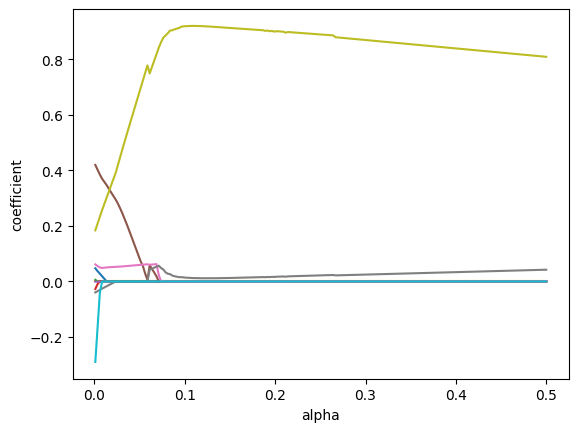

In [43]:
fig, ax = plt.subplots()
for column in elastic_coef.columns:
    ax.plot(alphas, elastic_coef[column], label=column)
ax.set_xlabel('alpha')
ax.set_ylabel('coefficient')

In [44]:
elastic_fit = smf.ols(full_model, df).fit_regularized('elastic_net', 0.1, 1.0)
print(elastic_fit.params[elastic_fit.params != 0])

enrollment   -0.000167
study_hrs     0.014059
exp_gpa       0.918561
dtype: float64


In [49]:
new_predictors = ['enrollment', 'study_hrs', 'exp_gpa']
new_formula = 'rec_gpa ~ ' + ' + '.join(new_predictors)
new_model = smf.ols(new_formula, df).fit()
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:                rec_gpa   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     8127.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:52:42   Log-Likelihood:                -1181.2
No. Observations:               18860   AIC:                             2370.
Df Residuals:                   18856   BIC:                             2402.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2842      0.030     -9.612      0.0